In [19]:
import numpy as np
import matplotlib.pyplot as plt
import heapq
import random
from matplotlib.patches import Rectangle
import math
from time import perf_counter
from collections import defaultdict

### CityMap
The class models a two dimensional grid-based city, using obstacles and weighted connections between neighboring cells. We designed this class to support applications such as path finding and simulations that require graph based representations of spatial environments. The class builds a graph where each non-obstructed cell is a node, the edges are possible movements between adjacent cells (undirected) and cells have associated travel costs (which we use to simulate traffic)

In [ ]:
class CityMap:    
    def __init__(self, height=15, width=15, num_obstacles=20, min_edge_weight=1.0, max_edge_weight=5.0):
        self.height = height
        self.width = width
        self.obstacles = set() # Set is used for O(1) lookup time
        self.edge_weights = {} # Dictionary stores weights between adjacent cells
        self.num_obstacles = min(num_obstacles, height * width // 4)  
        self.min_edge_weight = min_edge_weight
        self.max_edge_weight = max_edge_weight
        self.graph = {} # Stores adjacency list representation
        
        self.generate_random_map()
        self.build_graph()
    
    def generate_random_map(self):
        """
        Randomly pace obstacles accross the grid and assign weights to valid edges (i.e. between adjacent non-obstructed cells)
        Only rightward and downward connections are considered for weight assignment to avoid redundancy
        Reverse edges are edded to ensure bidirectional traversal
        """
        # Create obstacle locations by randomly sampling from all possible grid cells
        all_cells = [(i, j) for i in range(self.height) for j in range(self.width)]
        obstacle_cells = random.sample(all_cells, self.num_obstacles)
        self.obstacles = set(obstacle_cells)
        
        # Generate edge weights for adjacent nodes
        for i in range(self.height):
            for j in range(self.width):
                if (i, j) not in self.obstacles:
                    # Create right edge (horizontal connection) if it exists and it isn't an obstacle
                    if j + 1 < self.width and (i, j + 1) not in self.obstacles:
                        # Generate random weight and round to two 2 decimal places
                        weight = round(random.uniform(self.min_edge_weight, self.max_edge_weight), 2)
                        self.edge_weights[((i, j), (i, j + 1))] = weight
                        self.edge_weights[((i, j + 1), (i, j))] = weight
                    
                    # Create down edge (vertical connection) if it exists and it isn't an obstacle
                    if i + 1 < self.height and (i + 1, j) not in self.obstacles:
                        weight = round(random.uniform(self.min_edge_weight, self.max_edge_weight), 2)
                        self.edge_weights[((i, j), (i + 1, j))] = weight
                        self.edge_weights[((i + 1, j), (i, j))] = weight
    
    def build_graph(self):
        """
        Contruct the adjacency list representation of city map gaph
        For each non obstacle cell, add all accessible neighboring cells within bounds and not obstructed
        This allows us to build node connectivity for pathfinding
        """
        self.graph = {}
        
        for row in range(self.height):
            for col in range(self.width):
                # Skip obstacles
                if (row, col) in self.obstacles:
                    continue
                
                # Initialize adjacency list
                self.graph[(row, col)] = []
                directions = [(0, 1), (1, 0), (0, -1), (-1, 0)]
                
                # Check each direction for valid neighbours
                for dr, dc in directions:
                    nr, nc = row + dr, col + dc # Calculate neighbour coordinates
                    if (0 <= nr < self.height and # Add neighbour if it is within bounds and is not an obstacle
                        0 <= nc < self.width and 
                        (nr, nc) not in self.obstacles):
                        self.graph[(row, col)].append((nr, nc))
    
    def get_edge_weight(self, node1, node2):
        # Get weight between two adjacent nodes
        # Returns the weight of an edge  or 1.0 if not explicitly defined
        if (node1, node2) in self.edge_weights:
            return self.edge_weights[(node1, node2)]
        elif (node2, node1) in self.edge_weights:
            return self.edge_weights[(node2, node1)]
        else:
            return 1.0  # Default weight if not found
    
    def get_available_positions(self, count):
        # Get random available positions that aren't obstacles
        available = [(i, j) for i in range(self.height) for j in range(self.width) 
                   if (i, j) not in self.obstacles]
        
        if len(available) < count:
            # https://www.digitalocean.com/community/tutorials/python-valueerror-exception-handling-examples
            raise ValueError(f"Not enough available positions. Need {count}, have {len(available)}")
            
        return random.sample(available, count)
    
    def is_position_valid(self, position):
        # Check if a position is valid (in bounds and not an obstacle)
        row, col = position
        return (0 <= row < self.height and 
                0 <= col < self.width and 
                position not in self.obstacles)



### PathFinder
Path finder finds the shortest path between two points on a city grid. This class has two pathfinding algorithms that the user will be able to select A* and Djikstra. For more information on why we use these two and there benefits over the other, see the accompanying PDF.


In [ ]:
class PathFinder:
    # Handles pathfinding algorithms
    
    def __init__(self, city_map):
        self.city_map = city_map
    
    def heuristic(self, node, goal):
        #Manhattan distance heuristic for A*
        # Euclidean distance between coordinates of two points
        return abs(node[0] - goal[0]) + abs(node[1] - goal[1])
    
    def dijkstra(self, start, end):
        # Idea taken from notes
        # Implements Djikstra's algorithm
        if start not in self.city_map.graph or end not in self.city_map.graph:
            return [], float("inf")
        
        # Initialize data structures
        distances = {node: float("inf") for node in self.city_map.graph} # Keep track of shortest distance between each node
        distances[start] = 0 # Starting distance is zero
        previous = {node: None for node in self.city_map.graph} # Track predecessor for path reconstruction
        pq = [(0, start)] # Min heap (priority queue is ordered by distance)
        visited = set() # Keeps track of processed nodes
        
        while pq:
            current_distance, current_node = heapq.heappop(pq) # Get the node with the smallest distance from priority queue
            
            if current_node in visited: # Skip this node if we have already processed it
                continue
                
            visited.add(current_node) # Note is counted as visited
            
            if current_node == end: # We break out of the loop, if we have reached the intended desination
                break
                
            for neighbor in self.city_map.graph[current_node]: # For all neighbours of the current node
                if neighbor in visited: # If the neighbour has been already visited, then we can skip it
                    continue
                    
                edge_weight = self.city_map.get_edge_weight(current_node, neighbor) # Get the weight of the edge from the current node to the neighbouring node
                new_distance = distances[current_node] + edge_weight # Calculate the new distance to the neighbour
                
                if new_distance < distances[neighbor]: # If we find a better path to the neighbour, then we update it
                    distances[neighbor] = new_distance
                    previous[neighbor] = current_node
                    heapq.heappush(pq, (new_distance, neighbor))
        
        if distances[end] == float("inf"): # If no path to the end was found, return empty path and infinite distance
            return [], float("inf")
            
        # Reconstruct path by working backwards from the end point
        path = []
        current = end
        
        while current is not None:
            path.append(current)
            current = previous[current]
            
        path.reverse() # Reverse to get path from start to end
        
        return path, distances[end]
    
    def astar(self, start, end):
        """ 
        More efficient Variant of Djikstra's
        Similar to Djikstra's, check graph accessibility and initialise cost maps
        Uses a priority queue to explore nodes that appear most promising as guided by the cost so far and the heuristic
        Evaluates neighbors and update path and scores only when a better path is found (similar to Djikstra)
        Stosp the search once the end node is reached or all possibilities are exhausted
        """
        if start not in self.city_map.graph or end not in self.city_map.graph: # Check if start node and end nodes are valid. if so returns an empty path and infinite distance
            return [], float("inf") 
        
        # Initialize data structures
        open_set = [] # Priority queue of nodes
        closed_set = set() # Set of nodes already assessed
        g_score = {node: float("inf") for node in self.city_map.graph} # g_score is the exact cost from the starting node to the current node
        g_score[start] = 0
        f_score = {node: float("inf") for node in self.city_map.graph} # Total cost from start node to goal mode
        f_score[start] = self.heuristic(start, end) # Initial estimate is the heuristic 
        came_from = {node: None for node in self.city_map.graph} # Path reconstruction
        
        heapq.heappush(open_set, (f_score[start], start)) # Add start node to the open set
        
        while open_set:
            _, current = heapq.heappop(open_set) # Get the node with the lowest f_score from the open set
            
            if current == end: # If we've reached the goal node
                # Reconstruct path
                path = []
                while current is not None:
                    path.append(current)
                    current = came_from[current]
                path.reverse()
                return path, g_score[end]
                
            closed_set.add(current) # Move the current node from the open set to the closed set
            
            for neighbor in self.city_map.graph[current]: # Check all neighbours
                if neighbor in closed_set: # Skip neighbours if already assessed
                    continue
                    
                edge_weight = self.city_map.get_edge_weight(current, neighbor)
                tentative_g_score = g_score[current] + edge_weight # Calculate tentative g_score to this neighbour
                
                if tentative_g_score < g_score[neighbor]: # If we've found a better path to this neighbour, then update it
                    came_from[neighbor] = current # This path is better, so record it
                    g_score[neighbor] = tentative_g_score
                    f_score[neighbor] = g_score[neighbor] + self.heuristic(neighbor, end) # f_score is the sum of the g_score and the heuristic value (estimated cost from the current node to the goal node)
                    
                    if not any(node for _, node in open_set if node == neighbor): # Add neighbour to open set if not already present
                        heapq.heappush(open_set, (f_score[neighbor], neighbor))
        
        # No path found
        return [], float("inf")



### Driver
Model an individual driver in the system. Each driver has an identifier and location and boolean attributes to check if available. If assigned, current_path will hold the grid coordinates of the planned route.

In [ ]:
class Driver:
    #Driver class with location and status
    
    def __init__(self, id, location):
        self.id = id   # Unique identifier for the driver
        self.location = location # Current position as a grid coordinate
        self.is_available = True # Flag indicating if the driver can accept new passengers, intialised to True
        self.assigned_passenger = None # Reference to the currently assigned passenger, if any
        self.current_path = [] # List of coordinates for the driver's current route
    
    # This is the status quo for the OOP module last semester so we continued with it
    def __str__(self):
        status = "Available" if self.is_available else f"Assigned to {self.assigned_passenger}" # Displays either "Available" or which passenger the driver is assigned to
        return f"Driver {self.id} at {self.location}: {status}"


### Passenger
Similar to driver, this is an individual passenger with a ID and a pickup / dropoff location. There are also asignment booleans.


In [ ]:
class Passenger:
    # Passenger class with pickup and dropoff locations
    
    def __init__(self, id, pickup_location, dropoff_location):
        self.id = id # Unique identifer for the passenger
        self.pickup_location = pickup_location # Starting location/pickup location as coordinate
        self.dropoff_location = dropoff_location # Ending location/dropoff location as coordinate
        self.is_assigned = False # Flag indicating if the passenger has been assigned
        self.assigned_driver = None # Reference to the driver assigned to the passenger if any
    
    def __str__(self):
        status = f"Assigned to {self.assigned_driver}" if self.is_assigned else "Unassigned" # Displays either "Unassigned" or which driver the passenger is assigned to
        return f"Passenger {self.id}: {self.pickup_location} -> {self.dropoff_location} ({status})"


### Route Assigner
Connects drivers with passengers and calculates optimal routes between them. Manages the assignment workflow: tracks available entities, calculates route costs, performs assignments, provides statistics

In [ ]:
class RouteAssigner:
    # Handles assignment of drivers to passengers and route calculation
    
    def __init__(self, city_map, pathfinder):
        self.city_map = city_map
        self.pathfinder = pathfinder
        self.drivers = []
        self.passengers = []
        # passenger_id -> {driver, pickup_path, dropoff_path, total_cost}
        self.assignments = {}  
    
    def add_driver(self, driver):
        self.drivers.append(driver)
    
    def add_passenger(self, passenger):
        self.passengers.append(passenger)
    
    def generate_random_drivers_passengers(self, count):
        """
        Automates teh creation of a specific number of drivers and passengers and random non-obstacle locations
        Generate count drivers and count passengers ans assign unique IDs and add to the system.
        Consumer 3*count availbale positions in total
        """
        total_positions = count * 3 
        available_positions = self.city_map.get_available_positions(total_positions)
        
        # Create drivers with sequential IDs at the first count position
        for i in range(count):
            driver = Driver(f"driver_{i+1}", available_positions[i])
            self.add_driver(driver)
        
        # Create passengers with sequential IDs
        # Pickup locations start at index "count"
        # Dropoff locations start at index 2*count
        for i in range(count):
            pickup_idx = count + i
            dropoff_idx = count*2 + i
            passenger = Passenger(
                f"passenger_{i+1}", 
                available_positions[pickup_idx],
                available_positions[dropoff_idx]
            )
            self.add_passenger(passenger)
    
    def calculate_driver_passenger_distances(self, algorithm='astar'):
        """
        Calculate all viable pairings between available drivers and unassigned passengers, with the shortest path and travel cost to passenger's pickup location
        Can choose to use Djikstra or A*
        Filters out unreachable or already assigned individuals and returns a sorted list of valid pairing prioritised by shortest distance
        """
        distances = []
        
        algo_func = self.pathfinder.astar if algorithm == 'astar' else self.pathfinder.dijkstra # Select algorithm to use
        
        for driver in self.drivers: # Check each driver-passenger combination
            if not driver.is_available:
                continue # Skip drivers who are already assigned
                
            for passenger in self.passengers:
                if passenger.is_assigned:
                    continue # Skip passengers who are already assigned
                    
                path, distance = algo_func(driver.location, passenger.pickup_location) # Calculate path and distance from driver to pickup location
                
                if distance != float("inf"):  # If the pickup location is reachable (not infinity)
                    distances.append((driver, passenger, distance, path))
        
        # Sort by distance (shorter first)
        distances.sort(key=lambda x: x[2])
        return distances
    
    def assign_all_drivers_optimally(self, algorithm='astar'):
        """
        Perform greedy, distance based assignemnt of drivers to passengers
        Select the shortest available driver-passenger pair (from sorted list previous)
        Caclulate the pickup and dropoff paths and assign driver if both ar reachable
        Each assignment updates driver and passenger status adn stores detailed info in assignments dictionary including total route cost
        """
        
        self.reset_assignments()
        
        # Keep assigning until no more assignments can be made
        while True:
            # Get all possible driver-passenger pairs with distances
            distances = self.calculate_driver_passenger_distances(algorithm)
            
            if not distances:
                break  # No more valid assignments are possible
            # Get the closest driver-passenger combination
            driver, passenger, distance, pickup_path = distances[0]
            
            # Calculate the dropoff path and distance
            algo_func = self.pathfinder.astar if algorithm == 'astar' else self.pathfinder.dijkstra
            dropoff_path, dropoff_distance = algo_func(passenger.pickup_location, passenger.dropoff_location)
            
            if dropoff_distance == float("inf"):
                # If we can't reach dropoff location, skip this passenger
                # Mark as assigned to avoid trying again in future iterations
                passenger.is_assigned = True  
                continue
            
            # Make assignment by updating both objects
            driver.is_available = False
            driver.assigned_passenger = passenger.id
            driver.current_path = pickup_path
            
            # Reset all passengers to have an unassigned status
            passenger.is_assigned = True
            passenger.assigned_driver = driver.id
            
            # Store the assignment details
            self.assignments[passenger.id] = {
                'driver': driver,
                'pickup_path': pickup_path,
                'dropoff_path': dropoff_path,
                'pickup_distance': distance,
                'dropoff_distance': dropoff_distance,
                'total_distance': distance + dropoff_distance
            }
    
    def reset_assignments(self):
        # Reset all assignments
        self.assignments = {}
        
        # Reset all drivers to available status
        for driver in self.drivers:
            driver.is_available = True
            driver.assigned_passenger = None
            driver.current_path = []
        
        # Reset all passengers to unassigned status   
        for passenger in self.passengers:
            passenger.is_assigned = False
            passenger.assigned_driver = None
    
    def get_assignment_statistics(self):
        """
        As this models a real world system, it is logical to have a utility method that provides a summary report on current assignment performance
        In the real world this is used to help evaluate system efficiency, balance, identify bottlenecks, etc.
        """
        # Handle the case where there are no assignments
        if not self.assignments:
            return {
                'assigned_passengers': 0,
                'total_passengers': len(self.passengers),
                'avg_pickup_distance': 0,
                'avg_total_distance': 0,
                'longest_route': None,
                'shortest_route': None
            }
        
        # Calculate basic metrics
        assigned_count = len(self.assignments)
        total_pickup = sum(a['pickup_distance'] for a in self.assignments.values())
        total_distance = sum(a['total_distance'] for a in self.assignments.values())
        
        # Find longest and shortest routes
        longest = max(self.assignments.items(), key=lambda x: x[1]['total_distance'])
        shortest = min(self.assignments.items(), key=lambda x: x[1]['total_distance'])
        
        # Return a dictionary of statistics
        return {
            'assigned_passengers': assigned_count,
            'total_passengers': len(self.passengers),
            'avg_pickup_distance': total_pickup / assigned_count if assigned_count else 0,
            'avg_total_distance': total_distance / assigned_count if assigned_count else 0,
            'longest_route': (longest[0], longest[1]['total_distance']),
            'shortest_route': (shortest[0], shortest[1]['total_distance'])
        }



### Visualiser
Render a graphical representation of the routing system.
Print summary statistics

In [ ]:
class Visualizer:
    # Handles visualization of the city, drivers, passengers, and routes
    
    def __init__(self, city_map, route_assigner):
        self.city_map = city_map
        self.route_assigner = route_assigner
    
    def visualize_grid(self, show_weights=False):
        """Visualize the current state of the system"""
        fig, ax = plt.subplots(figsize=(12, 10))
        
        # Set the limits of the plot
        # https://www.geeksforgeeks.org/how-to-set-the-x-and-the-y-limit-in-matplotlib-with-python/
        ax.set_xlim(-0.5, self.city_map.width - 0.5)
        ax.set_ylim(-0.5, self.city_map.height - 0.5)
        
        # Draw the grid and obstacles
        for i in range(self.city_map.width):
            for j in range(self.city_map.height):
                if (j, i) in self.city_map.obstacles:
                    ax.add_patch(Rectangle((i - 0.5, j - 0.5), 1, 1, fill=True, color='black', alpha=0.7))
                else:
                    ax.add_patch(Rectangle((i - 0.5, j - 0.5), 1, 1, fill=False, edgecolor='gray', linewidth=0.5))
        
        # Show edge weights if requested
        if show_weights:
            for (node1, node2), weight in self.city_map.edge_weights.items():
                # Only show one direction to avoid duplicates
                # https://groups.google.com/g/gremlin-users/c/TdXHyHdRN1Q?pli=1
                if node1[0] <= node2[0] and node1[1] <= node2[1]:
                    mid_x = (node1[1] + node2[1]) / 2
                    mid_y = (node1[0] + node2[0]) / 2
                    ax.text(mid_x, mid_y, f'{weight:.1f}', fontsize=7, ha='center', va='center', 
                           bbox=dict(facecolor='white', alpha=0.7, pad=1))
        
        # Draw grid lines
        ax.grid(True, color='gray', linestyle='-', linewidth=0.5)
        ax.set_xticks(range(self.city_map.width))
        ax.set_yticks(range(self.city_map.height))
        
        # Plot drivers
        for driver in self.route_assigner.drivers:
            row, col = driver.location
            available = driver.is_available
            color = 'green' if available else 'gray'
            ax.plot(col, row, marker='o', markersize=10, color=color)
            ax.annotate(driver.id, (col, row), textcoords="offset points", xytext=(0, 5), ha='center')
        
        # Plot passengers
        for passenger in self.route_assigner.passengers:
            # Pickup
            p_row, p_col = passenger.pickup_location
            assigned = passenger.is_assigned
            pickup_color = 'blue' if not assigned else 'lightblue'
            ax.plot(p_col, p_row, marker='^', markersize=8, color=pickup_color)
            ax.annotate(f"{passenger.id} pickup", (p_col, p_row), 
                       textcoords="offset points", xytext=(0, 5), ha='center')
            
            # Dropoff
            d_row, d_col = passenger.dropoff_location
            ax.plot(d_col, d_row, marker='v', markersize=8, color='red')
            ax.annotate(f"{passenger.id} dropoff", (d_col, d_row), 
                       textcoords="offset points", xytext=(0, 5), ha='center')
        
        # Plot routes
        # https://matplotlib.org/stable/gallery/color/named_colors.html
        route_colors = ['purple', 'orange', 'cyan', 'magenta', 'yellow', 'lime', 'brown', 'pink', 'olive']
        
        for i, (passenger_id, assignment) in enumerate(self.route_assigner.assignments.items()):
            route_color = route_colors[i % len(route_colors)]
            
            # Plot pickup path
            pickup_path = assignment['pickup_path']
            if pickup_path:
                path_x = [point[1] for point in pickup_path]
                path_y = [point[0] for point in pickup_path]
                ax.plot(path_x, path_y, color=route_color, linewidth=2, alpha=0.7, linestyle='-')
                
                # Add arrow for direction
                for j in range(len(path_x) - 1):
                    mid_x = (path_x[j] + path_x[j+1]) / 2
                    mid_y = (path_y[j] + path_y[j+1]) / 2
                    dx = path_x[j+1] - path_x[j]
                    dy = path_y[j+1] - path_y[j]
                    
                    # Normalize arrow direction
                    length = np.sqrt(dx**2 + dy**2)
                    if length > 0:
                        dx /= length
                        dy /= length
                    
                    ax.arrow(mid_x - dx*0.2, mid_y - dy*0.2, dx*0.4, dy*0.4, 
                            head_width=0.15, head_length=0.15, fc=route_color, ec=route_color, alpha=0.7)
            
            # Plot dropoff path
            dropoff_path = assignment['dropoff_path']
            if dropoff_path:
                path_x = [point[1] for point in dropoff_path]
                path_y = [point[0] for point in dropoff_path]
                ax.plot(path_x, path_y, color=route_color, linewidth=2, alpha=0.7, linestyle='--')
                
                # Add arrow for direction
                for j in range(len(path_x) - 1):
                    mid_x = (path_x[j] + path_x[j+1]) / 2
                    mid_y = (path_y[j] + path_y[j+1]) / 2
                    dx = path_x[j+1] - path_x[j]
                    dy = path_y[j+1] - path_y[j]
                    
                    # Normalize arrow direction
                    length = np.sqrt(dx**2 + dy**2)
                    if length > 0:
                        dx /= length
                        dy /= length
                    
                    ax.arrow(mid_x - dx*0.2, mid_y - dy*0.2, dx*0.4, dy*0.4, 
                            head_width=0.15, head_length=0.15, fc=route_color, ec=route_color, alpha=0.7)
        
        # Labels and title
        ax.set_xlabel('Column')
        ax.set_ylabel('Row')
        ax.set_title('Taxi Routing System')
        
        # Invert y-axis so (0,0) is at the top-left
        ax.invert_yaxis()
        
        # Add legend
        legend_elements = [
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Available Driver'),
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=10, label='Assigned Driver'),
            plt.Line2D([0], [0], marker='^', color='w', markerfacecolor='blue', markersize=8, label='Pickup Location'),
            plt.Line2D([0], [0], marker='^', color='w', markerfacecolor='lightblue', markersize=8, label='Assigned Pickup'),
            plt.Line2D([0], [0], marker='v', color='w', markerfacecolor='red', markersize=8, label='Dropoff Location'),
            plt.Rectangle((0,0), 1, 1, facecolor='black', alpha=0.7, label='Obstacle'),
            plt.Line2D([0], [0], color='purple', linewidth=2, linestyle='-', label='Pickup Route'),
            plt.Line2D([0], [0], color='purple', linewidth=2, linestyle='--', label='Dropoff Route')
        ]
        
        ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.05, 1))
        
        # Adjust layout
        plt.tight_layout()
        plt.subplots_adjust(right=0.8)
        
        plt.show()
    
    def display_statistics(self):
        """Display statistics about routes and assignments"""
        stats = self.route_assigner.get_assignment_statistics()
        
        print("#### Routing Statistics ####")
        print(f"Grid Size: {self.city_map.height}x{self.city_map.width}")
        print(f"Number of Obstacles: {len(self.city_map.obstacles)}")
        print(f"Number of Drivers: {len(self.route_assigner.drivers)}")
        print(f"Number of Passengers: {len(self.route_assigner.passengers)}")
        
        print(f"Assigned Passengers: {stats['assigned_passengers']}/{stats['total_passengers']}")
        
        if stats['assigned_passengers'] > 0:
            print(f"Average pickup distance: {stats['avg_pickup_distance']:.2f}")
            print(f"Average total trip distance: {stats['avg_total_distance']:.2f}")
            
            longest = stats['longest_route']
            shortest = stats['shortest_route']
            
            if longest:
                print(f"Longest route: {longest[0]} - {longest[1]:.2f} units")
            if shortest:
                print(f"Shortest route: {shortest[0]} - {shortest[1]:.2f} units")
            
        # Show unassigned passengers
        unassigned = [p for p in self.route_assigner.passengers if not p.is_assigned]
        if unassigned:
            print(f"Unassigned passengers: {', '.join(p.id for p in unassigned)}")
            
            # Try to explain why they're unassigned
            for passenger in unassigned:
                pickup = passenger.pickup_location
                dropoff = passenger.dropoff_location
                
                # Check if pickup is reachable
                is_pickup_reachable = pickup in self.city_map.graph and self.city_map.graph[pickup]
                
                # Check if dropoff is reachable
                is_dropoff_reachable = dropoff in self.city_map.graph and self.city_map.graph[dropoff]
                
                if not is_pickup_reachable:
                    print(f"  {passenger.id}: Pickup location is unreachable")
                elif not is_dropoff_reachable:
                    print(f"  {passenger.id}: Dropoff location is unreachable")
                else:
                    print(f"  {passenger.id}: No available drivers to reach pickup location")



### Taxi Routing System
Manager of the simulation. Ties together the previously defined components

In [26]:
class TaxiRoutingSystem:
    # Main class to coordinates all components
    
    def __init__(self, grid_height=15, grid_width=15, num_obstacles=20, 
                num_actors=5, min_edge_weight=1.0, max_edge_weight=5.0):
        # Create city map
        self.city_map = CityMap(height=grid_height, width=grid_width, 
                             num_obstacles=num_obstacles,
                             min_edge_weight=min_edge_weight, 
                             max_edge_weight=max_edge_weight)
        
        # Create pathfinder
        self.pathfinder = PathFinder(self.city_map)
        
        # Create route assigner
        self.route_assigner = RouteAssigner(self.city_map, self.pathfinder)
        
        # Create visualizer
        self.visualizer = Visualizer(self.city_map, self.route_assigner)
        
        # Generate random drivers and passengers
        self.route_assigner.generate_random_drivers_passengers(num_actors)
    
    
    
    def run(self, algorithm='astar', visualize=True):
        # Run the taxi routing simulation
        # Assign drivers to passengers
        self.route_assigner.assign_all_drivers_optimally(algorithm)
        
        # Display statistics
        self.visualizer.display_statistics()
        
        # Visualize if requested
        if visualize:
            self.visualizer.visualize_grid(show_weights=True)


# Example usage function
def run_taxi_simulation(grid_height=15, grid_width=15, num_obstacles=20, 
                         num_actors=5, algorithm='astar', 
                         min_edge_weight=1.0, max_edge_weight=5.0):

    # Create the system
    taxi_system = TaxiRoutingSystem(
        grid_height=grid_height,
        grid_width=grid_width,
        num_obstacles=num_obstacles,
        num_actors=num_actors,
        min_edge_weight=min_edge_weight,
        max_edge_weight=max_edge_weight
    )
    
    # Run the system with the specified algorithm
    taxi_system.run(algorithm=algorithm, visualize=True)
    

        
    return taxi_system




We have written code below to show how to use the system. Feel free to uncomment the code to get the full experience of algorithm comparision, custom simulation or you can keep the code commented and see the default simulation


#### Routing Statistics ####
Grid Size: 15x15
Number of Obstacles: 20
Number of Drivers: 5
Number of Passengers: 5

Assigned Passengers: 5/5
Average pickup distance: 22.98
Average total trip distance: 60.45

Longest route: passenger_5 - 121.36 units
Shortest route: passenger_4 - 31.93 units


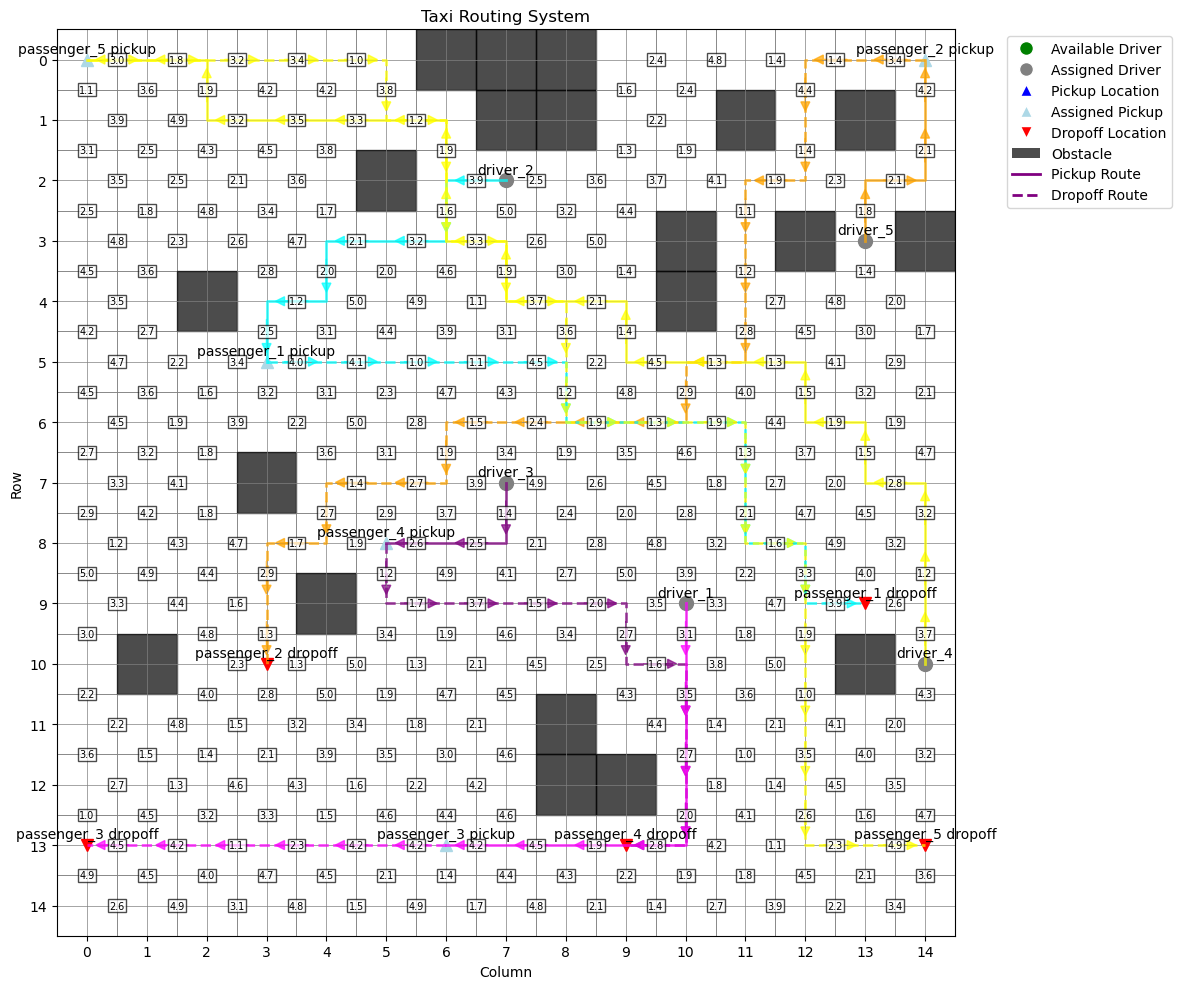

In [ ]:

# Set random seed for reproducibility (optional)
random.seed(42)
system = run_taxi_simulation()

# Example usage
# print("### Taxi Routing System ###")
# print("1. Default simulation")
# print("2. Custom simulation")
# print("3. Algorithm comparison")


# if choice == '1':
#     # Run with default parameters
#     system = run_taxi_simulation()
# elif choice == '2':
#     # Get custom parameters
#     try:
#         grid_height = int(input("Grid height (5-30): "))
#         grid_width = int(input("Grid width (5-30): "))
#         num_obstacles = int(input("Number of obstacles: "))
#         num_actors = int(input("Number of drivers/passengers: "))
#         algorithm = input("Algorithm (astar/dijkstra): ").lower()
        
#         # Validate inputs
#         grid_height = max(5, min(30, grid_height))
#         grid_width = max(5, min(30, grid_width))
#         num_obstacles = max(0, min(grid_height * grid_width // 3, num_obstacles))
#         num_actors = max(1, min(15, num_actors))
        
#         if algorithm not in ['astar', 'dijkstra']:
#             algorithm = 'astar'
            
#         system = run_taxi_simulation(
#             grid_height=grid_height,
#             grid_width=grid_width,
#             num_obstacles=num_obstacles,
#             num_actors=num_actors,
#             algorithm=algorithm
#         )
#     except ValueError:
#         print("Invalid input. Using default parameters.")
#         system = run_taxi_simulation()
# elif choice == '3':
#     # Run algorithm comparison
#     system = run_taxi_simulation(algorithm='compare')
# else:
#     print("Invalid choice. Running default simulation.")
#     system = run_taxi_simulation()